### IMPORTS

In [1]:
from Inference.Variational import MeanFieldVariationalDistribution

In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
def gaussian_entropy(sigma):
    return 0.5 * q.sigma.shape[0] * (1.0 + torch.log(2*torch.tensor(np.pi))) + torch.sum(torch.log(sigma))

In [5]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [6]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [7]:
# load data and make it in proper shape
data_val = torch.load('data/foong_data_validation.pt')
x_data_val = data_val[0].to(device)
y_data_val = data_val[1].to(device)
y_data_val = y_data_val.unsqueeze(-1)

In [8]:
model = nn.Sequential( nn.Linear(1, 100),
                       nn.Tanh(), 
                       nn.Linear(100, 1),
                     ).to(device)

In [9]:
param_count = get_param(model).shape[0]

In [10]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [11]:
def logprior(x):
    return prior.log_prob(x)

In [12]:
def loglikelihood(theta, model, x, y, sigma_noise):
    #set_param(model, theta)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [13]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [14]:
q = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
q.mu = nn.Parameter(prior.sample()[0,:].detach().clone().to(device), requires_grad=True) 

q.rho.requires_grad = True
q.mu.requires_grad = True

In [15]:
def flip_parameters_to_tensors(module):
    attr = []
    while bool(module._parameters):
        attr.append( module._parameters.popitem() )
    setattr(module, 'registered_parameters_name', [])

    for i in attr:
        setattr(module, i[0], torch.zeros(i[1].shape,requires_grad=True))
        module.registered_parameters_name.append(i[0])

    module_name = [k for k,v in module._modules.items()]

    for name in module_name:
        flip_parameters_to_tensors(module._modules[name])

In [16]:
def set_all_parameters(module, theta):
    count = 0  

    for name in module.registered_parameters_name:
        a = count
        b = a + getattr(module, name).numel()
        t = torch.reshape(theta[0,a:b], getattr(module, name).shape)
        setattr(module, name, t)

        count += getattr(module, name).numel()

    module_name = [k for k,v in module._modules.items()]
    for name in module_name:
        count += set_all_parameters(module._modules[name], theta)
    return count

In [17]:
flip_parameters_to_tensors(model)

In [18]:
n_samples_ELBO = 10

In [19]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

In [20]:
q.mu.detach_().requires_grad_(True)
q.rho.detach_().requires_grad_(True)

Parameter containing:
tensor([0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.

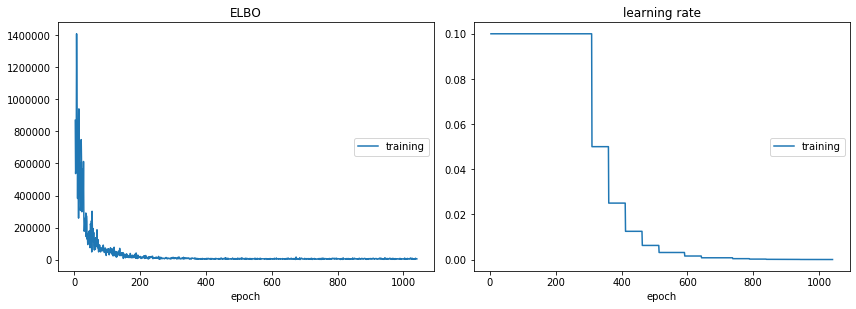

ELBO:
training   (min: 1553.833, max: 2197966.000, cur: 5492.541)

learning rate:
training   (min:    0.000, max:    0.100, cur:    0.000)


In [21]:
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    listDIV = []
    for i in range(n_samples_ELBO):
        z = q.sample(1)
        LQ = q.log_prob(z)
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        listDIV.append((LQ - LP))

    L = torch.stack(listDIV).mean()

    #with torch.no_grad():
    #    LL = predictive_loglikelihood(z).mean().detach().clone()

    L.backward()

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    #logs['memory'] = torch.cuda.memory_allocated(device=device)
    #logs['predictive likelihood'] = LL.detach().clone().cpu().numpy()
    liveloss.update(logs)

    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()

    if learning_rate < 0.00001:
        break

In [22]:
import matplotlib.pyplot as plt

In [23]:
LQ = []
LP = []
Z = []
for i in range(5000):
    z = q.sample(1)
    Z.append(z.detach().clone().cpu())
    LQ.append(q.log_prob(z).squeeze().squeeze().detach().clone().cpu().numpy())
    LP.append(logposterior(z, model, x_data, y_data, sigma_noise=0.5).squeeze().squeeze().detach().clone().cpu().numpy())

In [24]:
np.mean(np.stack(LQ) - 150 > np.stack(LP))

1.0

In [25]:
np.max(np.stack(LP) - np.stack(LQ))

-300.58078

In [26]:
np.max(np.exp(np.stack(LP) - np.stack(LQ) + 150))

0.0

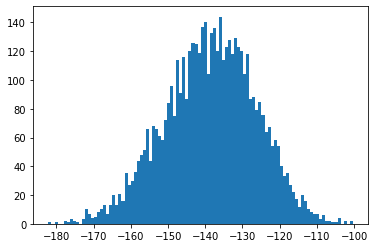

In [27]:
plt.hist(np.stack(LQ),bins=100);

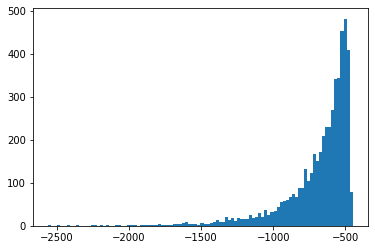

In [28]:
plt.hist(np.stack(LP),bins=100);

In [29]:
lw = torch.tensor(np.stack(LP) - np.stack(LQ))

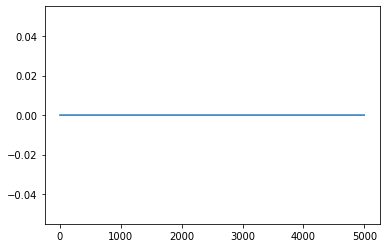

In [30]:
plt.plot(torch.exp(lw).cpu().numpy())

In [31]:
m = torch.distributions.Categorical(torch.exp(lw - torch.logsumexp(lw, dim=0)))

In [ ]:
m.sample()

In [175]:
P = torch.exp(lw - torch.logsumexp(lw, dim=0)).sort()

In [179]:
P[0][-10:-1]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.8813e-32, 3.7734e-08, 9.3415e-08])

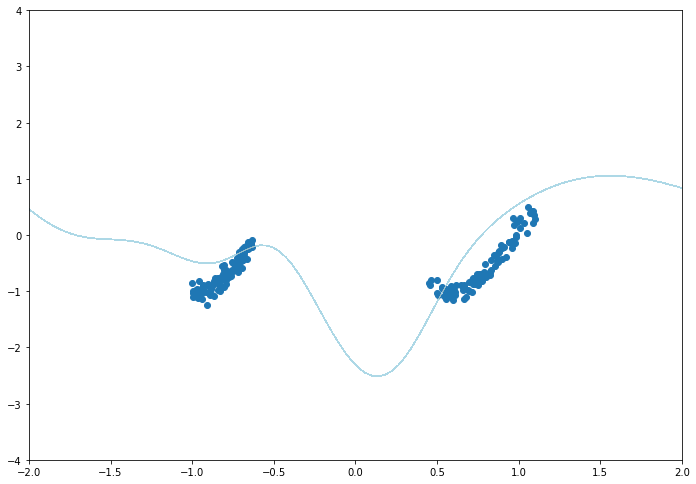

In [75]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = Z[m.sample()].to(device)
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [74]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)

In [ ]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = q.sample()
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [ ]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = prior.sample()
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')